# Bird Species Prediction using CNN (Transfer Learning)

This notebook trains a Convolutional Neural Network to classify bird species using the provided dataset. We utilize MobileNetV2 for transfer learning.

## 1. Setup and Data Loading
First, we mount Google Drive to access the dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset on your Drive - UPDATE THIS IF NEEDED
# Based on your request, the folder is likely named 'Birds dataset.jpg'
DATA_DIR = '/content/drive/MyDrive/parrots/Birds dataset.jpg'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np
import matplotlib.pyplot as plt

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets
print("Loading Training Data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int' # Sparse categorical
)

print("Loading Validation Data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
print(f"Classes found: {class_names}")

Loading Training Data...
Found 190 files belonging to 4 classes.
Using 152 files for training.
Loading Validation Data...
Found 190 files belonging to 4 classes.
Using 38 files for validation.
Classes found: ['amazon green parrot.jpg', 'gray parrot.jpg', 'macaw.jpg', 'white parrot.jpg']


## 2. Preprocessing
MobileNetV2 expects pixel values in [-1, 1], but `image_dataset_from_directory` loads them in [0, 255]. We'll use a rescaling layer.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 3. Model Architecture
We use MobileNetV2 as the base model, freeze its weights, and add a classification head.

In [6]:
# Create the base model from the pre-trained model MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # Freeze base model

# Create new model on top
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Training

In [7]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.5400 - loss: 1.2688 - val_accuracy: 0.8421 - val_loss: 0.7855
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7576 - loss: 0.7808 - val_accuracy: 0.9211 - val_loss: 0.5599
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8798 - loss: 0.4826 - val_accuracy: 0.8947 - val_loss: 0.4111
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9426 - loss: 0.3580 - val_accuracy: 0.8947 - val_loss: 0.3067
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9751 - loss: 0.2182 - val_accuracy: 0.9474 - val_loss: 0.2347
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9626 - loss: 0.1788 - val_accuracy: 0.9474 - val_loss: 0.1929
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9816 - loss: 0.1189 - val_accuracy: 0.9474 - val_loss: 0.1726
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9978 - loss: 0.1072 - val_accuracy: 0.9474 - val_loss: 0.1645
E

## 5. Evaluation & Saving

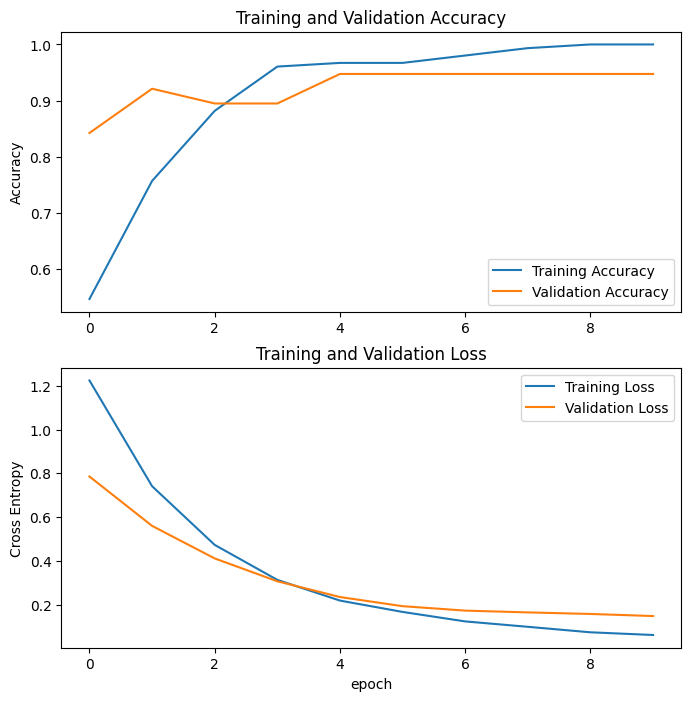

In [8]:
# Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
# Save the model
model.save('bird_model.h5')
print("Model saved as bird_model.h5")

# Optional: Save to Drive directly
# model.save('/content/drive/MyDrive/bird_model.h5')

Model saved as bird_model.h5
